In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [8]:
data_transforms = {
    'train' :transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
    ]),
    'val' :transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {
    x : datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
    for x in ['train','val']
}
dataloaders = {
    x : torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4)
    for x in ['train','val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

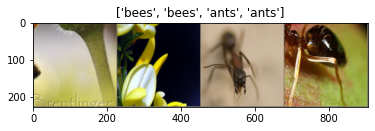

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, criterion, optimizer ,scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc :{best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model




In [26]:
def visualize_model(model,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far =0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)


In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [24]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss : 0.2478 Acc : 0.9016
val Loss : 0.2264 Acc : 0.9085

Epoch 1/24
----------
train Loss : 0.2914 Acc : 0.8893
val Loss : 0.2279 Acc : 0.9281

Epoch 2/24
----------
train Loss : 0.2294 Acc : 0.8975
val Loss : 0.2204 Acc : 0.9216

Epoch 3/24
----------
train Loss : 0.2679 Acc : 0.8730
val Loss : 0.2179 Acc : 0.9281

Epoch 4/24
----------
train Loss : 0.2161 Acc : 0.9098
val Loss : 0.2876 Acc : 0.8889

Epoch 5/24
----------
train Loss : 0.2821 Acc : 0.8852
val Loss : 0.2168 Acc : 0.9150

Epoch 6/24
----------
train Loss : 0.2705 Acc : 0.8770
val Loss : 0.2334 Acc : 0.9085

Epoch 7/24
----------
train Loss : 0.2119 Acc : 0.9057
val Loss : 0.2088 Acc : 0.9216

Epoch 8/24
----------
train Loss : 0.3148 Acc : 0.8320
val Loss : 0.2331 Acc : 0.9085

Epoch 9/24
----------
train Loss : 0.2633 Acc : 0.9016
val Loss : 0.2145 Acc : 0.9216

Epoch 10/24
----------
train Loss : 0.2259 Acc : 0.9057
val Loss : 0.2144 Acc : 0.9216

Epoch 11/24
----------
train Loss : 0.2092

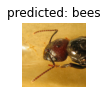

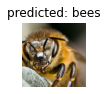

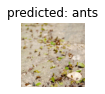

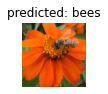

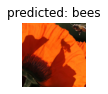

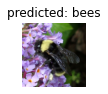

In [27]:
visualize_model(model_ft)

In [28]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss : 0.5521 Acc : 0.7008
val Loss : 0.2158 Acc : 0.9216

Epoch 1/24
----------
train Loss : 0.4960 Acc : 0.7623
val Loss : 0.2018 Acc : 0.9412

Epoch 2/24
----------
train Loss : 0.4316 Acc : 0.7951
val Loss : 0.1647 Acc : 0.9542

Epoch 3/24
----------
train Loss : 0.4002 Acc : 0.8156
val Loss : 0.1722 Acc : 0.9477

Epoch 4/24
----------
train Loss : 0.4694 Acc : 0.7951
val Loss : 0.1777 Acc : 0.9477

Epoch 5/24
----------
train Loss : 0.4439 Acc : 0.8197
val Loss : 0.2395 Acc : 0.9216

Epoch 6/24
----------
train Loss : 0.4913 Acc : 0.8074
val Loss : 0.1858 Acc : 0.9412

Epoch 7/24
----------
train Loss : 0.3489 Acc : 0.8648
val Loss : 0.1938 Acc : 0.9412

Epoch 8/24
----------
train Loss : 0.3322 Acc : 0.8320
val Loss : 0.1880 Acc : 0.9608

Epoch 9/24
----------
train Loss : 0.3125 Acc : 0.8770
val Loss : 0.1766 Acc : 0.9412

Epoch 10/24
----------
train Loss : 0.4024 Acc : 0.8238
val Loss : 0.1841 Acc : 0.9412

Epoch 11/24
----------
train Loss : 0.3278